In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Cross Validation Techiques
Dividing training and testing datasets for training purpose

### Different techniques for distributing dataset into training and testing dataset
1. Hold-Out CV
2. K-Fold Cross Validation
3. Repeated K-Fold
4. Leave-One-Out (LOO)
5. Stratified K-Fold

#### Note: These techniques are implemented over training dataset only. No augmented dataset is considered to make it less complex and produce the results.

### Different techniques and their obtained training accuracies

<table style="width:90%; font-size: 16px;">
    <tr>
        <th rowspan="2">Technique</th>
        <th rowspan="2">Average Accuracy across all classes</th>
        <th colspan="4">Per Class Average Accuracy</th>
    </tr>
    <tr>
        <th>Pituitary</th>
        <th>No Tumor</th>
        <th>Meningioma</th>
        <th>Glioma</th>
    </tr>
    <tr style='text-align: center;'>
        <td>Hold-Out CV</td>
        <td>0.9380</td>
        <td>0.9860</td>
        <td>0.9760</td>
        <td>0.8210</td>
        <td>0.9690</td>
    </tr>
    <tr style='text-align: center;'>
        <th>K-Fold CV</th>
        <th>0.9604</th>
        <th>0.9858</th>
        <th>0.9858</th>
        <th>0.9196</th>
        <th>0.9420</th>
    </tr>
    <tr style='text-align: center;'>
        <td>Repeated K-Fold CV</td>
        <td>0.9585</td>
        <td>0.9504</td>
        <td>0.9838</td>
        <td>0.9255</td>
        <td>0.9703</td>
    </tr>
    <tr style='text-align: center;'>
        <td>Stratified K-Fold CV</td>
        <td>0.9548</td>
        <td>0.9544</td>
        <td>0.9838</td>
        <td>0.9096</td>
        <td>0.9667</td>
    </tr>
</table>

#### Out of these techniques, K-Fold CV technique gives better overall accuracy and class wise accuracy.

In [3]:
path = '/kaggle/input/brain-tumor-mri-classification-dataset/Brain_Tumor_MRI_Image_Dataset/Training'

In [4]:
def get_dls_for_fold(train_indices, valid_indices):
    split_idx = IndexSplitter(valid_indices)
    dls = dblock.dataloaders(path, bs=64, splitter=split_idx)
    return dls

In [5]:
def train_and_evaluate(dls):
    learn = vision_learner(dls, resnet18, metrics=accuracy)  # Define your CNN architecture
    learn.fine_tune(epochs=3, base_lr=1e-2, freeze_epochs=1)  # Fine-tune the model
    
    # Get predictions on the validation set
    preds, _ = learn.get_preds(ds_idx=1)
    
    # Convert predictions to class indices
    preds_classes = preds.argmax(dim=1)
    
    # Extract actual labels from the validation set
    y_test = [parent_label(o) for o in dls.valid.items]
    
    # Convert predictions to class labels
    pred_labels = [learn.dls.vocab[i] for i in preds_classes]
    
    # Calculate accuracy
    acc = accuracy_score(y_test, pred_labels)
    print(f'Model accuracy on validation set: {acc}')
    return acc

# Hold-Out Cross Validation

Holdout cross-validation (CV) is a simple technique used to estimate the performance of a machine learning model. In this technique, the dataset is split into two subsets: a training set and a validation set (also known as a test set or holdout set). The dataset is randomly partitioned into two subsets: the training set and the validation set. Typically, the training set contains a larger portion of the data, such as 70-80%, while the validation set contains the remaining portion, such as 20-30%. Holdout CV can be performed multiple times by randomly splitting the dataset into training and validation sets each time. The average performance across multiple iterations can provide a more robust estimate of the model's performance.

#### Advantages:
- Simple and easy to implement.
- Fast training time, as it only trains the model on a subset of the data.

#### Disadvantages:
- High variance in estimated performance due to random selection of train/validation split.
- Sensitive to how the data is divided.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.983122,0.355160,0.863398,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.422748,0.202174,0.929947,00:20
1,0.285309,0.160441,0.939580,00:20
2,0.207024,0.154596,0.940455,00:20


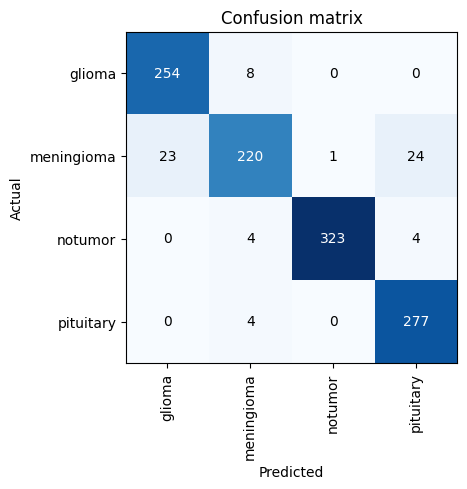

In [6]:
from fastai.vision.all import *

# Load Brain Tumor MRI Classification dataset (only training)
path = Path('/kaggle/input/brain-tumor-mri-classification-dataset/Brain_Tumor_MRI_Image_Dataset/Training')

# Create a DataBlock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(256),
                   batch_tfms=aug_transforms())

# Create DataLoaders
dls = dblock.dataloaders(path, bs=64)

# Train and fine tune the model
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(epochs=3, base_lr=1e-3, freeze_epochs=1)

# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [7]:
# Get predictions and true labels
preds, targets = learn.get_preds(dl=dls.valid)

# Get predicted labels
pred_labels = preds.argmax(dim=1)

# Calculate accuracy for each class
class_correct = {}
class_total = {}
for pred, target in zip(pred_labels, targets):
    if target.item() not in class_correct:
        class_correct[target.item()] = 0
        class_total[target.item()] = 0
    class_correct[target.item()] += (pred == target).float().sum().item()
    class_total[target.item()] += 1

# Calculate accuracy for each class
class_accuracies = {}
for cls in class_correct:
    class_accuracies[learn.dls.vocab[cls]] = class_correct[cls] / class_total[cls]

# Calculate average accuracy
average_accuracy = sum(class_accuracies.values()) / len(class_accuracies)

print(f'Per-class accuracies: {class_accuracies}')
print(f'Average accuracy across all classes: {average_accuracy:.4f}')

Per-class accuracies: {'pituitary': 0.9857651245551602, 'notumor': 0.9758308157099698, 'meningioma': 0.8208955223880597, 'glioma': 0.9694656488549618}
Average accuracy across all classes: 0.9380


# K-Fold Cross-Validation (K-Fold CV)

Divides the dataset into k equal-sized folds, trains the model k times, each time using k-1 folds as training data and one fold as validation data.

#### Advantages:
- Provides more accurate and reliable estimates of model performance compared to hold-out.
- Utilizes the entire dataset for training and validation.
#### Disadvantages:
- Increased computational cost due to multiple model trainings.
- Can be slower for large datasets and complex models.

In [8]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

# Load Brain Tumor MRI Classification dataset (only training)
path = Path('/kaggle/input/brain-tumor-mri-classification-dataset/Brain_Tumor_MRI_Image_Dataset/Training')

# Fastai DataBlock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(256))

# number of folds for K-Fold CV
k = 5  # This k value can be changed as per out requirements/ hyperparameter tuning

# Define K-Fold splitter
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Function to generate DataLoaders for each fold
def get_dls_for_fold(train_indices, valid_indices):
    split_idx = IndexSplitter(valid_indices)
    dls = dblock.dataloaders(path, bs=64, splitter=split_idx)
    return dls

# Train and evaluate the model for each fold
def train_and_evaluate(dls):
    learn = vision_learner(dls, resnet18, metrics=accuracy)  # Define your CNN architecture
    learn.fine_tune(epochs=3, base_lr=1e-3, freeze_epochs=1)  # Fine-tune the model
    
    # Get predictions on the validation set
    preds, _ = learn.get_preds(ds_idx=1)
    
    # Convert predictions to class indices
    preds_classes = preds.argmax(dim=1)
    
    # Extract actual labels from the validation set
    y_test = [parent_label(o) for o in dls.valid.items]
    
    # Convert predictions to class labels
    pred_labels = [learn.dls.vocab[i] for i in preds_classes]
    
    # Calculate accuracy
    acc = accuracy_score(y_test, pred_labels)
    print(f'Model accuracy on validation set: {acc}')
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, pred_labels, labels=learn.dls.vocab)
    print('Confusion Matrix:')
    print(cm)
    
    # Calculate per-class accuracies
    per_class_accuracies = {cls: cm[i, i] / cm[i, :].sum() for i, cls in enumerate(learn.dls.vocab)}
    print('Per-class accuracies:', per_class_accuracies)
    
    return acc, per_class_accuracies

# Performing K-Fold Cross-Validation
accuracies = []
per_class_accuracies = {}
for train_indices, valid_indices in kf.split(np.arange(len(dblock.get_items(path)))):
    dls = get_dls_for_fold(train_indices, valid_indices)
    acc, per_class_acc = train_and_evaluate(dls)
    accuracies.append(acc)
    for cls, val in per_class_acc.items():
        per_class_accuracies[cls] = per_class_accuracies.get(cls, []) + [val]

print(f'Mean accuracy over {k} folds: {np.mean(accuracies)}')
print('Average accuracy across all classes:', {cls: np.mean(accs) for cls, accs in per_class_accuracies.items()})

epoch,train_loss,valid_loss,accuracy,time
0,0.874660,0.335748,0.878284,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.340696,0.185882,0.929947,00:19
1,0.151337,0.148914,0.950088,00:19
2,0.071042,0.148642,0.949212,00:19


Model accuracy on validation set: 0.9492119089316988
Confusion Matrix:
[[241  23   0   1]
 [  6 233   5  13]
 [  0   4 310   1]
 [  0   5   0 300]]
Per-class accuracies: {'glioma': 0.909433962264151, 'meningioma': 0.9066147859922179, 'notumor': 0.9841269841269841, 'pituitary': 0.9836065573770492}


epoch,train_loss,valid_loss,accuracy,time
0,0.878811,0.367263,0.871278,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.347669,0.155526,0.941331,00:19
1,0.176812,0.124712,0.957093,00:19
2,0.084967,0.105955,0.963222,00:19


Model accuracy on validation set: 0.9632224168126094
Confusion Matrix:
[[250  15   0   0]
 [ 11 248   6   5]
 [  0   1 306   1]
 [  0   2   1 296]]
Per-class accuracies: {'glioma': 0.9433962264150944, 'meningioma': 0.9185185185185185, 'notumor': 0.9935064935064936, 'pituitary': 0.9899665551839465}


epoch,train_loss,valid_loss,accuracy,time
0,0.914320,0.320107,0.892294,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.343205,0.171296,0.939580,00:19
1,0.167071,0.124998,0.958844,00:19
2,0.073472,0.119346,0.959720,00:19


Model accuracy on validation set: 0.9597197898423818
Confusion Matrix:
[[256   5   0   0]
 [ 14 235   3  15]
 [  1   4 328   1]
 [  0   2   1 277]]
Per-class accuracies: {'glioma': 0.9808429118773946, 'meningioma': 0.8801498127340824, 'notumor': 0.9820359281437125, 'pituitary': 0.9892857142857143}


epoch,train_loss,valid_loss,accuracy,time
0,0.851312,0.288622,0.899300,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.334055,0.169288,0.943082,00:20
1,0.163251,0.127787,0.957968,00:19
2,0.078864,0.110160,0.961471,00:19


Model accuracy on validation set: 0.9614711033274956
Confusion Matrix:
[[231  16   0   0]
 [  6 258   3   6]
 [  0   6 324   2]
 [  0   5   0 285]]
Per-class accuracies: {'glioma': 0.9352226720647774, 'meningioma': 0.945054945054945, 'notumor': 0.9759036144578314, 'pituitary': 0.9827586206896551}


epoch,train_loss,valid_loss,accuracy,time
0,0.939101,0.304562,0.898424,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.306447,0.172837,0.945709,00:19
1,0.159208,0.124723,0.958844,00:19
2,0.073662,0.120710,0.968476,00:19


Model accuracy on validation set: 0.968476357267951
Confusion Matrix:
[[252  16   0   0]
 [  3 237   6   4]
 [  0   1 320   1]
 [  0   5   0 297]]
Per-class accuracies: {'glioma': 0.9402985074626866, 'meningioma': 0.948, 'notumor': 0.9937888198757764, 'pituitary': 0.9834437086092715}
Mean accuracy over 5 folds: 0.9604203152364275
Average accuracy across all classes: {'glioma': 0.9418388560168207, 'meningioma': 0.9196676124599528, 'notumor': 0.9858723680221596, 'pituitary': 0.9858122312291273}


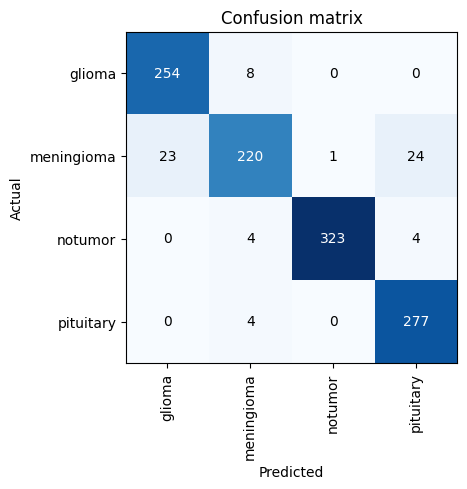

In [9]:
# Evaluate the model: Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [10]:
# Get predictions and true labels
preds, targets = learn.get_preds(dl=dls.valid)

# Get predicted labels
pred_labels = preds.argmax(dim=1)

# Calculate accuracy for individual class
class_correct = {}
class_total = {}
for pred, target in zip(pred_labels, targets):
    if target.item() not in class_correct:
        class_correct[target.item()] = 0
        class_total[target.item()] = 0
    class_correct[target.item()] += (pred == target).float().sum().item()
    class_total[target.item()] += 1

# Calculate accuracy for each class
class_accuracies = {}
for cls in class_correct:
    class_accuracies[learn.dls.vocab[cls]] = class_correct[cls] / class_total[cls]

# Calculate average accuracy
average_accuracy = sum(class_accuracies.values()) / len(class_accuracies)

print(f'Per-class accuracies: {class_accuracies}')
print(f'Average accuracy across all classes: {average_accuracy:.4f}')

Per-class accuracies: {'pituitary': 0.9834437086092715, 'notumor': 0.9968944099378882, 'glioma': 0.9776119402985075, 'meningioma': 0.892}
Average accuracy across all classes: 0.9625


# Repeated K-Fold

Repeats the k-fold CV process multiple times with different random splits of the data.

#### Advantages:
- Provides more robust estimates of model performance by averaging results over multiple iterations.

#### Disadvantages:
- Further increases computational cost compared to standard k-fold CV.

#### Table for accuracies over 5 folds and 2 repeats

<table style="width:90%; font-size: 16px; border-collapse: collapse; border: 1px solid black;">
    <tr>
        <th rowspan="2" style="border: 1px solid black;">Repeats</th>
        <th colspan="5" style="border: 1px solid black;">Average Accuracy across all folds</th>
    </tr>
    <tr>
        <th style="border: 1px solid black;">k = 1</th>
        <th style="border: 1px solid black;">k = 2</th>
        <th style="border: 1px solid black;">k = 3</th>
        <th style="border: 1px solid black;">k = 4</th>
        <th style="border: 1px solid black;">k = 5</th>
    </tr>
    <tr style='text-align: center;'>
        <th style="border: 1px solid black;">Repeat 1</th>
        <td style="border: 1px solid black;">0.9518</td>
        <td style="border: 1px solid black;">0.9606</td>
        <td style="border: 1px solid black;">0.9483</td>
        <td style="border: 1px solid black;">0.9527</td>
        <td style="border: 1px solid black;">0.9562</td>
    </tr>
    <tr style='text-align: center;'>
        <th style="border: 1px solid black;">Repeat 2</th>
        <td style="border: 1px solid black;">0.9544</td>
        <td style="border: 1px solid black;">0.9711</td>
        <td style="border: 1px solid black;">0.9685</td>
        <td style="border: 1px solid black;">0.9685</td>
        <td style="border: 1px solid black;">0.9553</td>
    </tr>
</table>


In [15]:
from sklearn.metrics import accuracy_score, classification_report
from fastai.vision.all import *

# Function to train and evaluate the model for each k fold
def train_and_evaluate(dls):
    learn = vision_learner(dls, resnet18, metrics=accuracy)  # CNN architecture
    learn.fine_tune(epochs=3, base_lr=1e-3, freeze_epochs=1)  # Fine-tune
    
    # Get predictions on the validation set
    preds, _ = learn.get_preds(ds_idx=1)
    
    preds_classes = preds.argmax(dim=1)
    
    y_true = [parent_label(o) for o in dls.valid.items]
    
    y_pred = [learn.dls.vocab[i] for i in preds_classes] # class labels
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f'Model accuracy on validation set: {acc}')
    
    # Calculate per-class accuracy
    report = classification_report(y_true, y_pred, output_dict=True)
    per_class_acc = {k: v['precision'] for k, v in report.items() if k in learn.dls.vocab}
    
    return acc, per_class_acc, y_true, y_pred

In [16]:
from sklearn.model_selection import RepeatedKFold

# number of folds and repeats for Repeated K-Fold CV
k = 5  # number of folds: can be changes as per our requirements/hyperparameter tuning
n_repeats = 2  # number of repeats
random_state = 42

# Repeated K-Fold splitter
rkf = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=random_state)

# Repeated K-Fold Cross-Validation
accuracies = []
per_class_accuracies = {}
confusion_matrices = []  # Store confusion matrices for each fold
for train_indices, valid_indices in rkf.split(np.arange(len(get_image_files(path)))):
    dls = get_dls_for_fold(train_indices, valid_indices)
    acc, per_class_acc, y_true, y_pred = train_and_evaluate(dls)
    accuracies.append(acc)
    for cls, val in per_class_acc.items():
        per_class_accuracies[cls] = per_class_accuracies.get(cls, []) + [val]
    
    # confusion matrix for each fold and repeat
    cm = confusion_matrix(y_true, y_pred, labels=dls.vocab)
    confusion_matrices.append(cm)

print(f'Mean accuracy over {k} folds and {n_repeats} repeats: {np.mean(accuracies)}')
print('Average accuracy across all classes:', {cls: np.mean(accs) for cls, accs in per_class_accuracies.items()})

epoch,train_loss,valid_loss,accuracy,time
0,0.927386,0.391773,0.883538,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.331890,0.219358,0.934326,00:20
1,0.149091,0.180868,0.946585,00:19
2,0.076283,0.166910,0.951839,00:19


Model accuracy on validation set: 0.9518388791593695


epoch,train_loss,valid_loss,accuracy,time
0,0.831081,0.332055,0.883538,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.335378,0.169845,0.945709,00:19
1,0.155675,0.130412,0.952715,00:19
2,0.075373,0.123876,0.960595,00:19


Model accuracy on validation set: 0.9605954465849387


epoch,train_loss,valid_loss,accuracy,time
0,0.887765,0.327670,0.886165,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.325123,0.191464,0.933450,00:19
1,0.164001,0.166841,0.947461,00:19
2,0.075410,0.150259,0.948336,00:19


Model accuracy on validation set: 0.9483362521891419


epoch,train_loss,valid_loss,accuracy,time
0,0.836924,0.353537,0.876532,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.303429,0.209265,0.927320,00:19
1,0.148602,0.161820,0.944834,00:19
2,0.070310,0.152012,0.952715,00:19


Model accuracy on validation set: 0.9527145359019265


epoch,train_loss,valid_loss,accuracy,time
0,0.892513,0.339135,0.874781,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.328436,0.200757,0.928196,00:19
1,0.158093,0.121819,0.953590,00:19
2,0.073712,0.112010,0.956217,00:19


Model accuracy on validation set: 0.9562171628721541


epoch,train_loss,valid_loss,accuracy,time
0,0.865760,0.307427,0.890543,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.337747,0.173772,0.941331,00:19
1,0.163012,0.136121,0.957093,00:19
2,0.070422,0.132450,0.954466,00:19


Model accuracy on validation set: 0.9544658493870403


epoch,train_loss,valid_loss,accuracy,time
0,0.874036,0.273401,0.907180,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.333165,0.132472,0.951839,00:19
1,0.162187,0.094839,0.966725,00:19
2,0.076412,0.086275,0.971103,00:19


Model accuracy on validation set: 0.9711033274956217


epoch,train_loss,valid_loss,accuracy,time
0,0.819699,0.296197,0.895797,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.333520,0.151991,0.942207,00:19
1,0.154630,0.113349,0.964974,00:19
2,0.073308,0.105840,0.965849,00:19


Model accuracy on validation set: 0.9658493870402802


epoch,train_loss,valid_loss,accuracy,time
0,0.816408,0.299998,0.894921,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.328952,0.175537,0.947461,00:19
1,0.157011,0.119962,0.968476,00:19
2,0.075143,0.122440,0.968476,00:19


Model accuracy on validation set: 0.968476357267951


epoch,train_loss,valid_loss,accuracy,time
0,0.869713,0.313012,0.885289,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.327476,0.167768,0.937828,00:19
1,0.159842,0.132373,0.953590,00:19
2,0.077982,0.133435,0.955342,00:19


Model accuracy on validation set: 0.9553415061295972
Mean accuracy over 5 folds and 2 repeats: 0.9584938704028021
Average accuracy across all classes: {'glioma': 0.9703241198317392, 'meningioma': 0.9255884020066073, 'notumor': 0.9838723338861992, 'pituitary': 0.95045790443823}


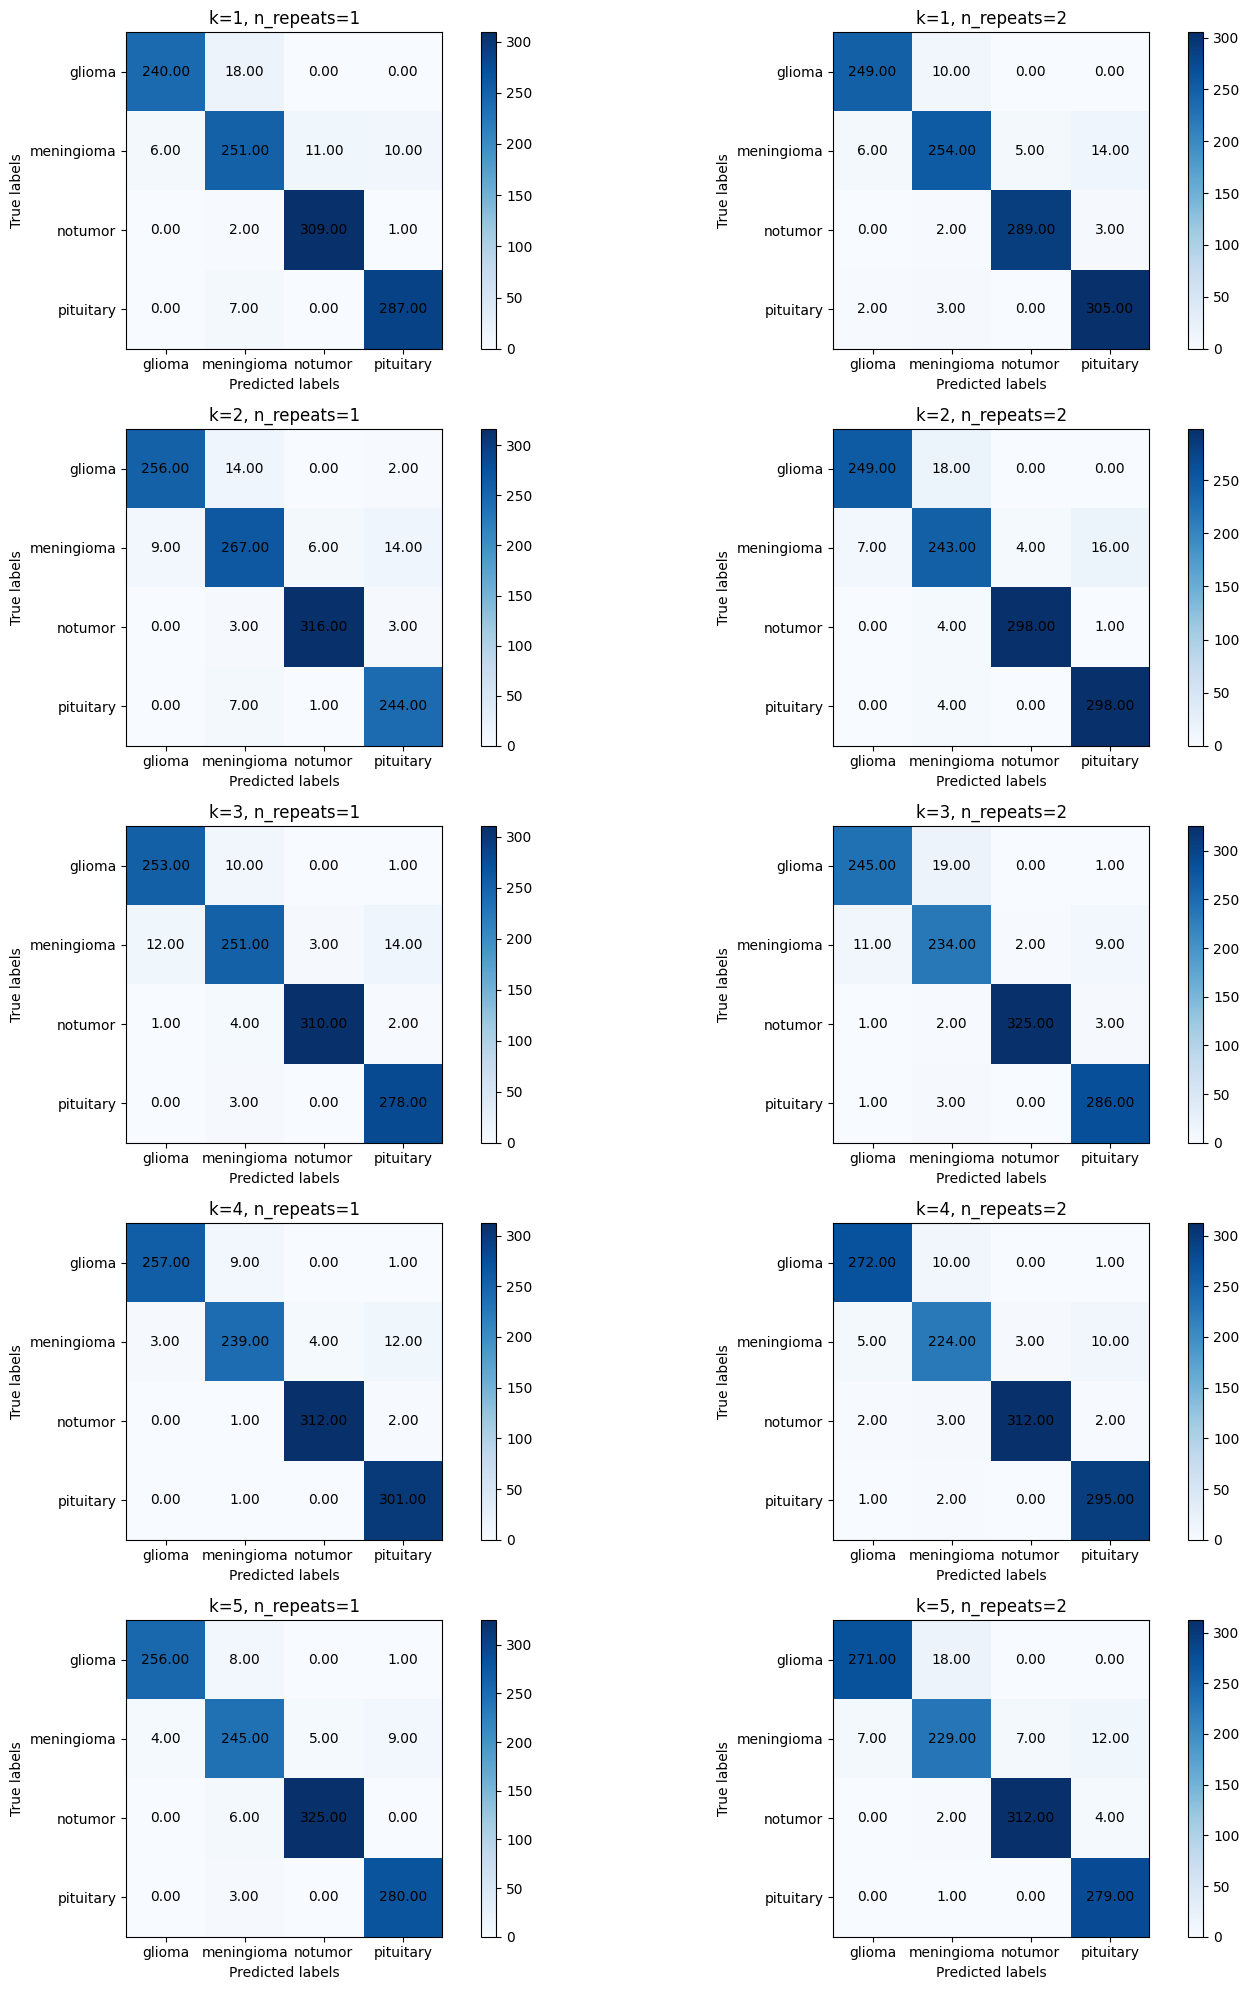

In [27]:
# number of folds (k) and repeats (n_repeats)
k_values = [i for i in range(1, 6)]
n_repeats_values = [1, 2]

# Create subplots for different combinations of k and n_repeats
fig, axes = plt.subplots(len(k_values), len(n_repeats_values), figsize=(15, 20))

for i, k in enumerate(k_values):
    for j, n_repeats in enumerate(n_repeats_values):
        
        # Get the confusion matrix for the corresponding fold and repeat
        cm = confusion_matrices[i * len(n_repeats_values) + j]  # Adjust index for confusion_matrices
        
        # Plot the confusion matrix
        ax = axes[i, j]
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'k={k}, n_repeats={n_repeats}')
        plt.colorbar(im, ax=ax)
        
        for m in range(len(dls.vocab)):
            for n in range(len(dls.vocab)):
                ax.text(n, m, format(cm[m, n], '.2f'), horizontalalignment='center', verticalalignment='center', color='black')

        ax.set_xticks(np.arange(len(dls.vocab)))
        ax.set_yticks(np.arange(len(dls.vocab)))
        ax.set_xticklabels(dls.vocab)
        ax.set_yticklabels(dls.vocab)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()

# Leave One Out

A special case of k-fold CV where k is equal to the number of samples in the dataset. Each sample is used as a validation set once.

#### Advantages:
- Provides least biased estimate of model performance.

#### Disadvantages:
- Extremely computationally expensive, especially for large datasets.
- High variance in performance estimate due to the single-sample validation sets.


For LOO CV, each data point is held out once as the validation set, and the model is trained on the remaining data points. So, if we have n data points, we will have to train the model  n times. Since LOO CV trains the model n times, the training time for each iteration depends on the size of the dataset, model architecture, and hardware resources. It can be significantly higher compared to other CV methods, especially for large datasets. In LOO CV, each data point is used once as the validation set, and the model is trained on the remaining n−1 data points. This process is repeated for each data point in dataset, resulting in n iterations, where n is the number of data points in your dataset. Therefore, for n images, we will indeed need to train the model n times in LOO CV and we have more than 5000 images for training. For this method is not feasible and will take a lot of time to execute.

# Stratified K-Fold

Like k-fold CV, but ensures that each fold preserves the percentage of samples for each class.

#### Advantages:
- Particularly useful for imbalanced datasets, providing more representative validation sets.

#### Disadvantages:
- Slightly higher computational cost compared to standard k-fold CV due to the extra stratification step.

In [30]:
from sklearn.metrics import accuracy_score, classification_report
from fastai.vision.all import *

# train and evaluate the model for each fold
def train_and_evaluate(dls):
    learn = vision_learner(dls, resnet18, metrics=accuracy)  # CNN architecture
    learn.fine_tune(epochs=3, base_lr=1e-3, freeze_epochs=1)  # Fine-tune 
    
    preds, _ = learn.get_preds(ds_idx=1)
    
    preds_classes = preds.argmax(dim=1)
    
    y_true = [parent_label(o) for o in dls.valid.items]
    
    y_pred = [learn.dls.vocab[i] for i in preds_classes]
    
    acc = accuracy_score(y_true, y_pred)
    print(f'Model accuracy on validation set: {acc}')
    
    report = classification_report(y_true, y_pred, output_dict=True)
    per_class_acc = {k: v['precision'] for k, v in report.items() if k in learn.dls.vocab}
    
    return acc, per_class_acc, y_true, y_pred

In [31]:

from sklearn.model_selection import StratifiedKFold

# Number of folds for Stratified K-Fold CV
k = 5  # number of folds

# Stratified K-Fold splitter
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Stratified K-Fold Cross-Validation
accuracies = []
per_class_accuracies = {}
confusion_matrices = []  # Store confusion matrices for each fold
for train_indices, valid_indices in skf.split(np.arange(len(get_image_files(path))), [parent_label(o) for o in get_image_files(path)]):
    dls = get_dls_for_fold(train_indices, valid_indices)
    acc, per_class_acc, y_true, y_pred = train_and_evaluate(dls)
    accuracies.append(acc)
    for cls, val in per_class_acc.items():
        per_class_accuracies[cls] = per_class_accuracies.get(cls, []) + [val]
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=dls.vocab)
    confusion_matrices.append(cm)

print(f'Mean accuracy over {k} folds: {np.mean(accuracies)}')
print('Average accuracy across all classes:', {cls: np.mean(accs) for cls, accs in per_class_accuracies.items()})

epoch,train_loss,valid_loss,accuracy,time
0,0.903851,0.316393,0.891419,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.338887,0.184448,0.941331,00:19
1,0.156008,0.133695,0.959720,00:19
2,0.071222,0.133809,0.960595,00:19


Model accuracy on validation set: 0.9605954465849387


epoch,train_loss,valid_loss,accuracy,time
0,0.891530,0.367875,0.885289,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.306223,0.225318,0.929072,00:19
1,0.145077,0.187035,0.941331,00:19
2,0.068084,0.173529,0.944834,00:19


Model accuracy on validation set: 0.9448336252189142


epoch,train_loss,valid_loss,accuracy,time
0,0.914143,0.383797,0.873905,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.330520,0.221491,0.928196,00:19
1,0.150833,0.171103,0.953590,00:19
2,0.076399,0.164667,0.953590,00:20


Model accuracy on validation set: 0.9535901926444834


epoch,train_loss,valid_loss,accuracy,time
0,0.862717,0.305703,0.895797,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.316800,0.188480,0.936953,00:19
1,0.158771,0.123750,0.961471,00:19
2,0.066293,0.121189,0.960595,00:19


Model accuracy on validation set: 0.9605954465849387


epoch,train_loss,valid_loss,accuracy,time
0,0.872977,0.379292,0.881786,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.328655,0.220226,0.930823,00:19
1,0.167332,0.184127,0.954466,00:19
2,0.079687,0.167778,0.954466,00:19


Model accuracy on validation set: 0.9544658493870403
Mean accuracy over 5 folds: 0.954816112084063
Average accuracy across all classes: {'glioma': 0.966718847934783, 'meningioma': 0.9096564314102453, 'notumor': 0.9838569239608793, 'pituitary': 0.9544664477148981}


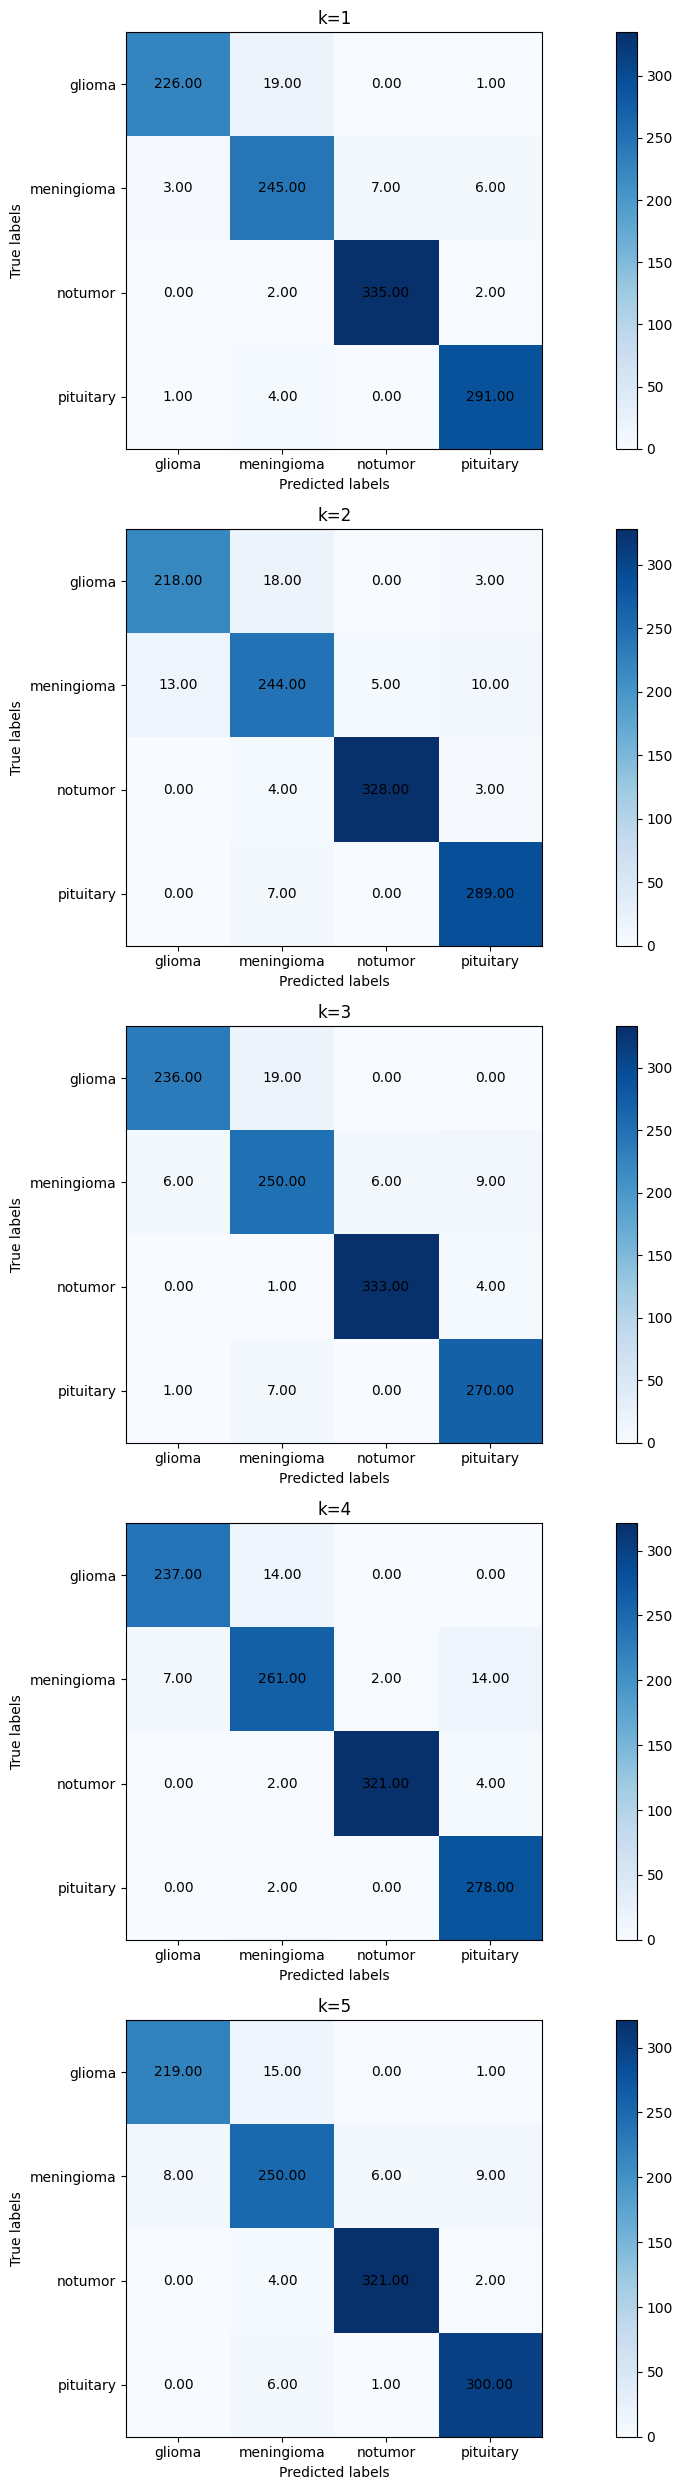

In [32]:
# number of folds (k)
k_values = [i for i in range(1, 6)]

fig, axes = plt.subplots(len(k_values), 1, figsize=(15, 5 * len(k_values)))

for i, k in enumerate(k_values):
    cm = confusion_matrices[i]
    
    ax = axes[i]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # confusion matrix display
    ax.set_title(f'k={k}')
    plt.colorbar(im, ax=ax)
    
    for m in range(len(dls.vocab)):
        for n in range(len(dls.vocab)):
            ax.text(n, m, format(cm[m, n], '.2f'), horizontalalignment='center', verticalalignment='center', color='black')

    ax.set_xticks(np.arange(len(dls.vocab)))
    ax.set_yticks(np.arange(len(dls.vocab)))
    ax.set_xticklabels(dls.vocab)
    ax.set_yticklabels(dls.vocab)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()